# Exploratory data analysis with PostgreSQL

## Introduction:

During my third year of bachelor's in Computer Sciences, I was introduced to the idea of recommender systems by a buddy of mine since then recommender systems been one of the most thought-provoking Machine learning algorithms for me. Today I'm going to introduce a recommendation algorithm that's a regression-based hybrid of content-based and collaborative filtering recommender systems. This Hybrid recommendation algorithm is highly inspired by the recommender systems approach of Andrew ng along with some research papers, I have attached in references

The dataset is provided by [GroupLens](https://grouplens.org/about/what-is-grouplens/) and  can be downloaded from [here](https://grouplens.org/datasets/movielens/) it contains the following files(links.csv, movies.csv, ratings.csv, and tags.csv)

<blockquote>"This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996, and September 24, 2018. This dataset was generated on September 26, 2018."</blockquote>

In this part of the project, I'm going to perform Exploratory data analysis with PostgreSQL.The idea to use PostgreSQL for EDA gives you a sense of how the relational database works, how data in it is stored, and more importantly how to get data out of the database. SQL is a very flexible declarative language and can be used to pose a rich set of queries to get data out of the database even tho it's not Turing complete but its ability to perform data manipulation is exceptional and makes it a great companion to have during EDA I'm going to use SQL queries for data manipulation for almost every single graphical EDA technique today along with some other python libraries mainly for visualization 

## Importing libraries

In [11]:
import pkg_resources
print(pkg_resources.get_distribution("seaborn").version)


0.13.2


In [16]:
import numpy
print(numpy.__version__)


1.20.3


In [3]:
!pip install numpy==1.21.6 matplotlib==3.4.3 seaborn==0.11.2


  Using cached numpy-1.21.6-cp38-cp38-win_amd64.whl (14.0 MB)
  Using cached matplotlib-3.4.3-cp38-cp38-win_amd64.whl (7.1 MB)
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached scipy-1.10.1-cp38-cp38-win_amd64.whl (42.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\AI\\Projects\\Hybrid-recommendation-system-web-application\\env\\Lib\\site-packages\\~-mpy\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Check the permissions.

You should consider upgrading via the 'd:\ai\projects\hybrid-recommendation-system-web-application\env\scripts\python.exe -m pip install --upgrade pip' command.


In [19]:
!pip uninstall numpy matplotlib seaborn -y
!pip install numpy matplotlib seaborn


Found existing installation: numpy 1.21.6
Uninstalling numpy-1.21.6:
  Successfully uninstalled numpy-1.21.6
Found existing installation: matplotlib 3.4.3
Uninstalling matplotlib-3.4.3:
  Successfully uninstalled matplotlib-3.4.3
Found existing installation: seaborn 0.11.2
Uninstalling seaborn-0.11.2:
  Successfully uninstalled seaborn-0.11.2
  Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl (14.9 MB)
  Using cached matplotlib-3.7.5-cp38-cp38-win_amd64.whl (7.5 MB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.24.4 which is incompatible.
You should consider upgrading via the 'c:\python38\python.exe -m pip install --upgrade pip' command.


In [5]:
import matplotlib
print(matplotlib.__version__)


3.7.5


In [6]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Check if imports work without errors
print("All imports successful!")


All imports successful!


## Loading dataset

In [8]:
#loading data from csv files into pandas dataframes
moviesData=pd.read_csv(r'D:\AI\Projects\Hybrid-recommendation-system-web-application\Data\movies.csv')
ratingsData=pd.read_csv(r'D:\AI\Projects\Hybrid-recommendation-system-web-application\Data\ratings.csv')
linksData=pd.read_csv(r'D:\AI\Projects\Hybrid-recommendation-system-web-application\Data\links.csv')
tagsData=pd.read_csv(r'D:\AI\Projects\Hybrid-recommendation-system-web-application\Data\tags.csv')


In [9]:
#I have one column named Timestamp'' in my RatingData I've to rename it to something else before inserting data into SQL tables because the timestamp is a  data type in SQL
ratingsData['timestamp'] = pd.to_datetime(ratingsData['timestamp'], unit='s')
ratingsData.columns = ['userId', 'movieId','rating' ,'timing']
ratingsData[:5]



,userId,movieId,rating,timing
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [10]:

moviesData[:5]


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
linksData[:5]

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
tagsData[:5]

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Accessing PostgreSQL Database Server from Python with ODBC
To establish a connection to my PostgreSQL Database Server I'm gonna be using odbc (Open Database Connectivity) that's the standard that says if you write to through this protocol this standard API then you can work with ODBC it accomplishes DBMS independence by using an ODBC driver as a translation layer between the application and the DBMS. The application uses ODBC functions through an ODBC driver manager with which it is linked, and the driver passes the query to the DBMS. An ODBC driver can be thought of as analogous to a printer driver or other driver, providing a standard set of functions for the application to use, and implementing DBMS-specific functionality. An application that can use ODBC is referred to as "ODBC-compliant". Any ODBC-compliant application can access any DBMS for which a driver is installed. Drivers exist for all major DBMSs and it's a plug-and-play kind of thing so there are drivers for ODBC for databases like Oracle, PostgreSQL, MySQL, and Microsoft SQL Server but you've to manually install DBMS of your choice and configure its driver before using it in your python code here I've already done it for PostgreSQL hence, I can use my PostgreSQL DRIVER named {PostgreSQL Unicode} in my code to establish the connection to PostgreSQL Database

<b> Please pay pilgrimage to PostgreSQLconnection class I have defined in PostgreSQL_Database_wrapper.py to understand the methods I'm going to use. I've provided docstrings for all methods that I'm going to use with my PostgreSQLconnection object here </b>

In [1]:
#importing PostgreSQLconnection class from my PostgreSQL_Database_wrapper file and creating an instance of it
from PostgreSQL_Database_wrapper import PostgreSQLconnection
db=PostgreSQLconnection("drecommendersystem_db","postgres","fusion1234","localhost")

Successfully connected to database.


## Creating Tables in PostgreSQL Server
MovieLens dataset consists of four [.csv] files namely (`links.csv`, `movies.csv`, `ratings.csv`, and `tags.csv`)  I've loaded these files into pandas' data from dataframes. Now I'm going to create tables using SQL and load data frames in these tables in PostgreSQL Server by calling PostgreSQLconnection.create_table()  defined in PostgreSQL_Database_wrapper.py and passing SQL statement as argument to it

Here I've four tables with both<b> PRIMARY KEY  Constraint and FOREIGN KEY Constraint.</b>

<blockquote>The FOREIGN KEY constraint identifies the relationships between the database tables by referencing a column or set of columns, in the Child table that contains the foreign key, to the PRIMARY KEY column or set of columns, in the Parent table.</blockquote>
<blockquote>
The PRIMARY KEY constraint uniquely identifies each record in a table.
</blockquote>
    
Most importantly, after looking at the data in data frames I noticed my data is not in <b>First normal form (1NF)</b>  
<blockquote>
The first normal form (1NF) is a property of a relation in a relational database. A relation is in first normal form if and only if the domain of each attribute contains only atomic.
</blockquote>
That means each attribute/field/column should contain one and only one value hence a list of values in one (row, column) pair is a violation of the 1NF form and I have two problematic tables. 
The first one is Tags with attribute/field/column " tag" containing multiple values in single  (row, column) pair similarly in case of table "MovieData" I've attribute/field/column " generes" containing multiple values in single  (row, column) pair, Generally when designing schema for DBMS you've to make sure your data is in 1NF which always going to hold true if you follow the standard ER-Diagrams in conceptual design, ER-model enforces atomicity in fields/attributes and in next phase of logical design where you will translate your ER-Model into the data model(mostly likely Relational Model) your tables will be in 1NF. Now back to my problem I'm gonna do something stupid and assume values in fields like " generes" and " tag" are a long atomic string of character because I'm not going to create any critical important  application that uses this database and enforces standard to be used, if it was the case I will first do the One-hot encoding for each non-atomic field that will extend the number of columns

In [14]:
#sql statement to create table
sqlstatement='''CREATE TABLE Movies(
              movieId INT,
              title text,
              genres text,
              PRIMARY KEY(movieId)
              )'''
db.create_table(sqlstatement, ' Movies')
#sql statement to create table
sqlstatement='''CREATE TABLE Rating(
              userId INT,
              movieId INT,
              rating REAL,
              timing TIMESTAMP,
              PRIMARY KEY(movieId,userId),
              FOREIGN KEY(movieId) 
                  REFERENCES Movies(movieId)
              )'''
db.create_table(sqlstatement, ' Ratings')
#sql statement to create table
sqlstatement='''CREATE TABLE Links(
              movieId INT,
              imdbId INT,
              tmdbId REAL,
              PRIMARY KEY(movieId)
              )'''
db.create_table(sqlstatement, ' Links')
#sql statement to create table
sqlstatement='''CREATE TABLE Tags(
              userId INT,
              movieId INT,
              tag text,
              PRIMARY KEY(movieId,userId),
              FOREIGN KEY(movieId) 
                  REFERENCES Links(movieId)
              )'''
db.create_table(sqlstatement, ' Tags')

Table created successfully with name Movies
Table created successfully with name Ratings
Table created successfully with name Links
Table created successfully with name Tags


following are the tables being created in database as resut of above code
1. Movies
2. Rating
3. Links
4. Tags

For a better understanding of these tables and the relational schema, I'm going to embed ER-Diagram for this database design


As it can be seen from my ER-Diagram I've four entities one for each table along with their primary and foreign keys for demonstrating relationships I've used crowfoot notation 


![title](images/ERD1.jpg)

## Loading Data into tables from dataFrames
After creating my tables now I've to load data from data frames into tables


In [15]:
'''
Accessing cursor attribute of PostgreSQLconnection object that itself holds an object of the cursor then using it to insert data
into my tables(it's a bad practice to access any attribute from outside of your class it violates encapsulation and information
hiding, unfortunately, there is no way to enforce information hiding in python that's why hacks like this one will work but make
sure whenever you define your classes they are as loosely coupled as possible always follow SOLID principles) tbh I forgot to 
implement insert_data method in PostgreSQLconnection class that's the reason I'm accessing it from outside 
'''
cursor = db.cursor
for row in moviesData.itertuples():
    cursor.execute('''
                        INSERT INTO Movies(movieId,title,genres)
                        VALUES (?,?,?)
                        ''',
                        row.movieId,
                        row.title,
                        row.genres
                  )
db.db_connection.commit()
print("successfully inserted data from DataFrame into table")
for row in ratingsData.itertuples():
    cursor.execute('''
                        INSERT INTO Rating(userId,movieId,rating,timing)
                        VALUES (?,?,?,?)
                        ''',
                        row.userId,
                        row.movieId,
                        row.rating,
                        row.timing
                  )
db.db_connection.commit()
print("successfully inserted data from DataFrame into table")

successfully inserted data from DataFrame into table
successfully inserted data from DataFrame into table


In [25]:
# cursor = db.cursor
# for row in linksData.itertuples():
#     cursor.execute('''
#                         INSERT INTO Links(movieId,imdbId,tmdbId)
#                         VALUES (?,?,?)
#                         ''',
#                         row.movieId,
#                         row.imdbId,
#                         row.tmdbId
#                   )
# db.db_connection.commit()
# print("successfully inserted data from DataFrame into table")
# for row in tagsData.itertuples():
#     cursor.execute('''
#                         INSERT INTO Tags(userId,movieId,tag)
#                         VALUES (?,?,?)
#                         ''',
#                         row.userId,
#                         row.movieId,
#                         row.tag
#                   )
# db.db_connection.commit()
# print("successfully inserted data from DataFrame into table")
cursor = db.cursor

# Inserting data into Links table
for row in linksData.itertuples():
    cursor.execute('''
        INSERT INTO Links(movieId, imdbId, tmdbId)
        VALUES (?, ?, ?)
        ON CONFLICT (movieId) DO NOTHING
    ''',
    (row.movieId, row.imdbId, row.tmdbId))
db.db_connection.commit()
print("Successfully inserted data from DataFrame into Links table")

# Inserting data into Tags table
for row in tagsData.itertuples():
    cursor.execute('''
        INSERT INTO Tags(userId, movieId, tag)
        VALUES (?, ?, ?)
        ON CONFLICT (userId, movieId) DO NOTHING
    ''',
    (row.userId, row.movieId, row.tag))
db.db_connection.commit()
print("Successfully inserted data from DataFrame into Tags table")


Successfully inserted data from DataFrame into Links table
Successfully inserted data from DataFrame into Tags table


# Exploratory Data Analysis
Now I'm all set for EDA.
EDA by using SQL queries can be more flexible instead of doing it on Pandas Dataframes but be cautious it can act as a double-edged sword since it's not very efficient nevertheless the flexible queries you can pose in PostgrSql database for EDA is phenomenal

## Top ten most rated movies 
Taking join of Rating and Movies table then creating view named "MoviesWithRatings" and executing query over this View MoviesWithRating to extract top ten most rated movies

### Taking Join then creating View of result

In [26]:
#taking Join of tables(Rating and movies) then creating View(MoviesWithRatings) of result
command ='''
CREATE VIEW MoviesWithRatings AS
    SELECT Rating.userId,Rating.movieId,Rating.rating,Movies.title
    FROM Rating
    LEFT JOIN Movies
    ON Rating.movieId = Movies.movieId;
'''
db.run_command(command)

successfull execution of command


###  executing query over view 

In [27]:
#executing query over view 
query = '''
SELECT title, count(movieid) AS movies_count
FROM MoviesWithRatings
GROUP BY title,movieid
ORDER BY movies_count DESC
LIMIT 10;
'''
query_result=db.run_query(query)
query_result

,title,movies_count
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
5,Star Wars: Episode IV - A New Hope (1977),251
6,Jurassic Park (1993),238
7,Braveheart (1995),237
8,Terminator 2: Judgment Day (1991),224
9,Schindler's List (1993),220


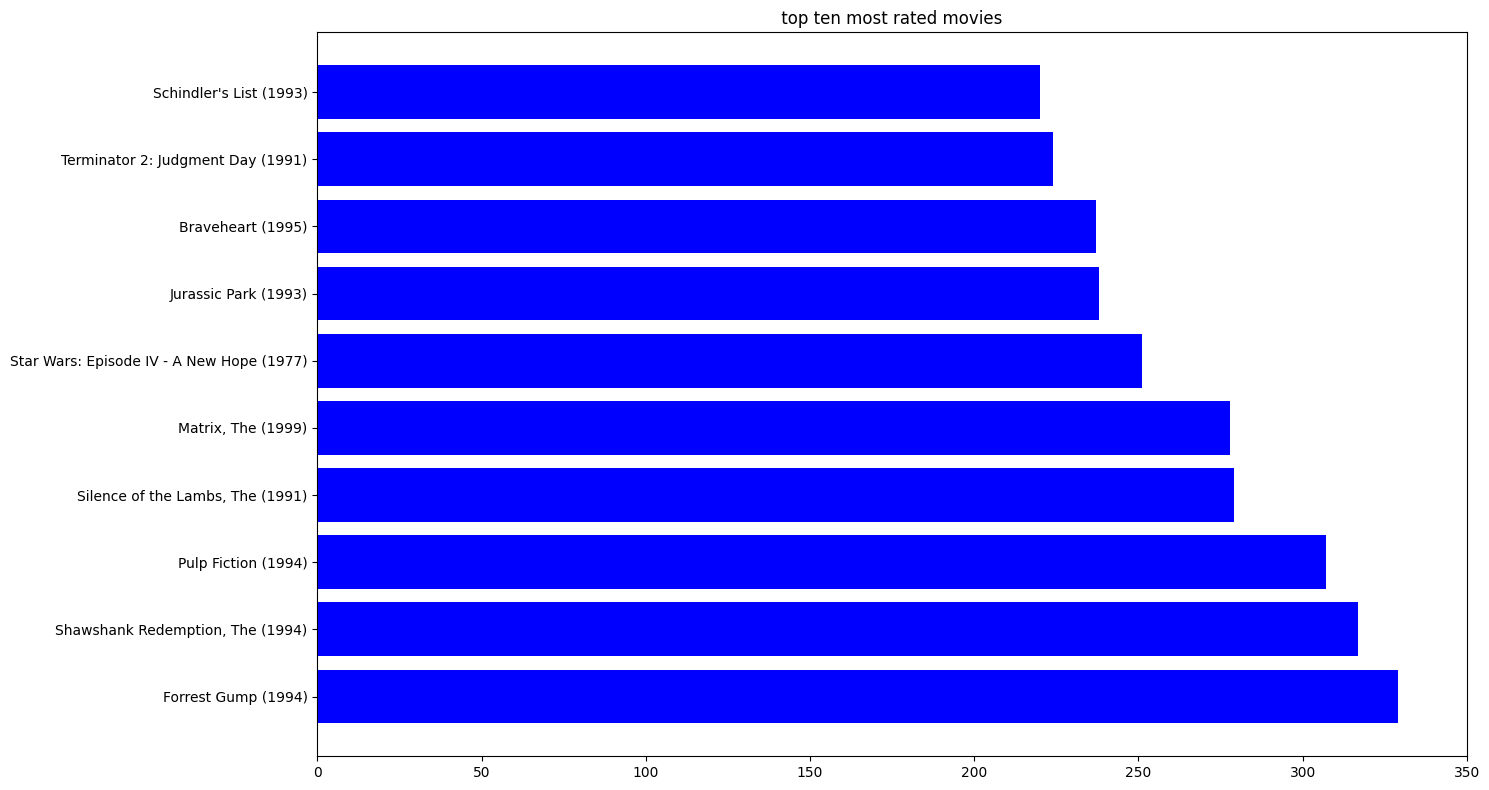

In [28]:
plt.figure(figsize=(15, 8))
barh = plt.barh(query_result['title'], query_result['movies_count'], color='blue')
plt.title(' top ten most rated movies ')
plt.xticks(np.arange(0, 400, 50))
plt.tight_layout()

### Observation:
good gracious! the result is very similar to what you will find on rotten tomatoes and IMDb.Indeed these are the greatest movies of all time endure for all kinds of reasons – they offer plots that twist and turn, give us characters that we fall in love with, depict experiences that change us, and thrill us with incredible filmmaking craft but most importantly this result verify my small dataset from MovieLens is representative enough to be used for training

## Most popular genres among directors
now i'm posing query for each genre to count the number of movies contains that genre as a substring in "generes"  field/attribute/column and appending result in a list for later use to plot it


In [29]:
genres_unique = pd.DataFrame(moviesData.genres.str.split('|').tolist()).stack().unique()
genres_list=genres_unique[:len(genres_unique)-1]
genres_count=[]

In [30]:
for genre in genres_list:
    query = '''
    SELECT count(Movies.movieId) 
    FROM  Movies
    where Movies.genres LIKE '%'''+genre+'''%'
    '''
    query_result=db.run_query(query)
    genres_count.append(query_result.iloc[0]['count'])


In [31]:
data=pd.DataFrame({'x': genres_list, 'y': genres_count})


C:\Users\priya\AppData\Local\Temp\ipykernel_12852\837851538.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.x, y=data.y, palette="rocket")


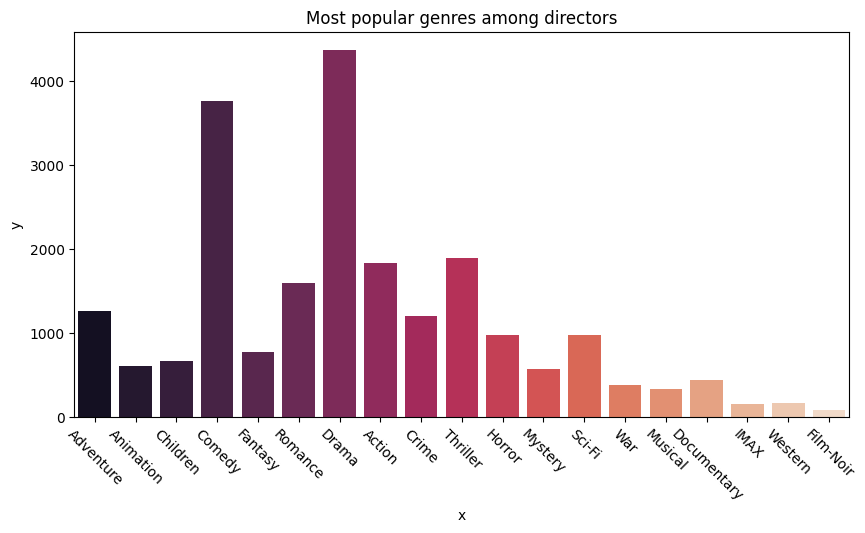

In [32]:
data=pd.DataFrame({'x': genres_list, 'y': genres_count})
plt.subplots(figsize=(10,5))
sns.barplot(x=data.x, y=data.y, palette="rocket")
plt.xticks(rotation=-45)
plt.title('Most popular genres among directors');

### Observation:
clearly users seem to enjoy "Drama" genre the most next Two Most popular genres among directors are "comedy" and "thriller" 

## Number of ratings each year

In [33]:
#executing Nested query over table rating
query = '''
SELECT year,count(year)
FROM( SELECT rating.movieId,EXTRACT(year FROM rating.timing) AS year
      FROM rating) AS derivedTable
GROUP BY year
ORDER BY year DESC;

'''
query_result=db.run_query(query)
query_result

,year,count
0,2018.0,6418
1,2017.0,8198
2,2016.0,6703
3,2015.0,6616
4,2014.0,1439
5,2013.0,1664
6,2012.0,4656
7,2011.0,1690
8,2010.0,2301
9,2009.0,4158


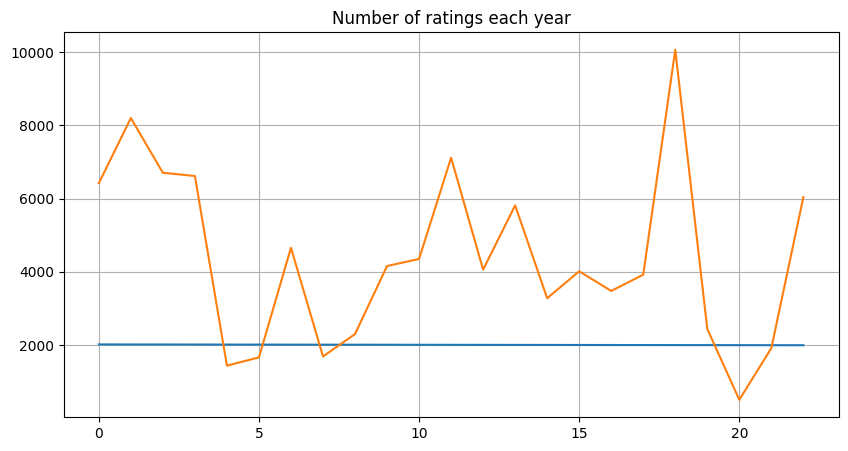

In [34]:
query_result
plt.subplots(figsize=(10,5))
plt.plot(query_result)

plt.grid(True)
plt.title('Number of ratings each year');

### Observation:
huh! I was expecting exponential growth in ratings each year given more and more people around the world joining the internet every year so what went wrong? well this result just points towards the fact this small MovieLens dataset is cherry-picked that's why it's not reflective enough of real data consistency in every expect  

##  Number of movies per Year

In [35]:
#executing Nested query over table movies
query ='''
SELECT year,Count(year)
FROM(SELECT DISTINCT title, movieId ,year
     FROM(SELECT DISTINCT Rating.movieId,Movies.title,EXTRACT(year FROM Rating.timing) AS year
          FROM Movies
          LEFT OUTER JOIN Rating
          ON Movies.movieId=Rating.movieId) AS derivedTable
     GROUP BY title, movieId, year) AS derivedTable
GROUP BY year
ORDER BY year

'''
result=db.run_query(query)

In [36]:
result=result[:len(result)-1]

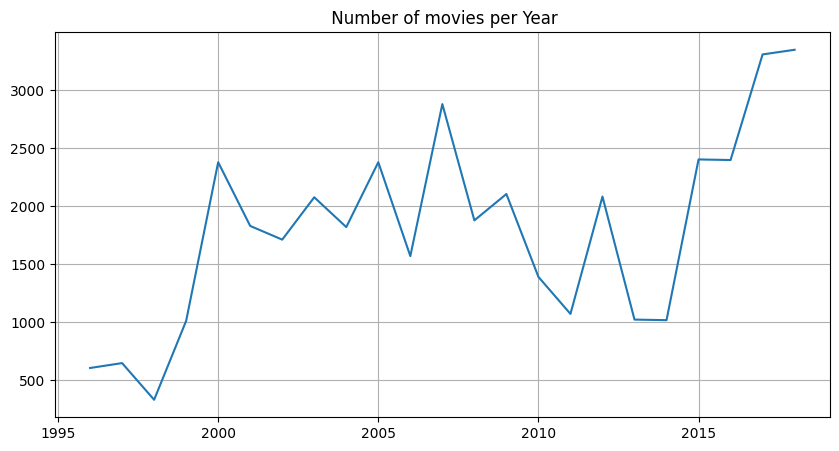

In [37]:

plt.subplots(figsize=(10,5))
plt.plot(result['year'],result['count'])
plt.grid(True)
plt.title(' Number of movies per Year');

### Observation:
Again I was expecting exponential growth in the number of movies made each year, but for the same reason as discussed above, I have randomness in my data and no trend


## Distribution of  ratings
let's explore (1)how users being rating movies based on genre,(2)How many different genres are in the dataset, and (3)how are they distributed?


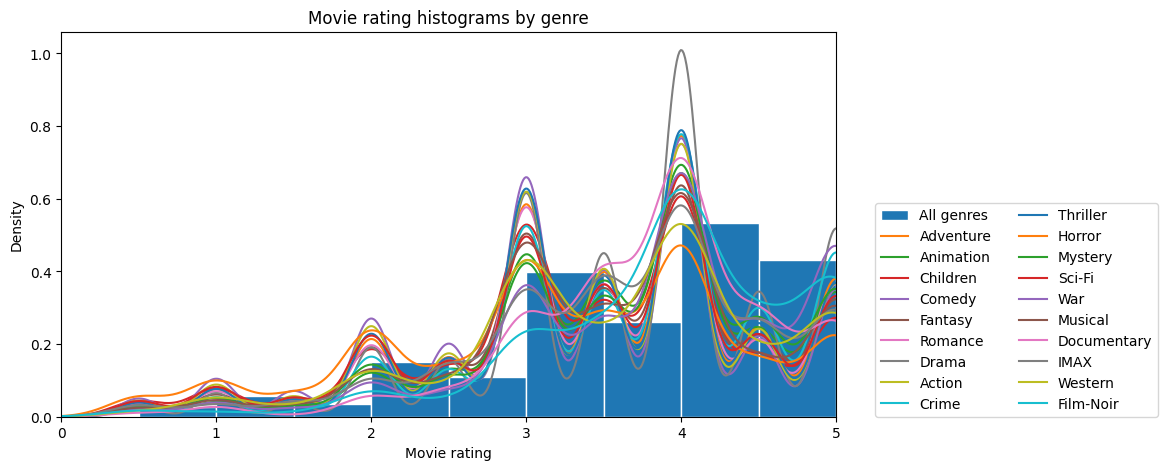

In [40]:
# #executing query over rating table
# query = '''
# SELECT rating
# FROM Rating
# '''
# rating_result=db.run_query(query)
# rating_result.hist(bins=9, grid=False, edgecolor='w',density = True, label ='All genres', figsize=(10,5))
# #extracting out all genre from moviesData using pandas
# genres_unique = pd.DataFrame(moviesData.genres.str.split('|').tolist()).stack().unique()
# genres_list=genres_unique[:len(genres_unique)-1]
# #executing Nested queries within looping structure over table join of rating and movies and doing string comparision for each genre
# for genre in genres_list:
#     query = '''
#     SELECT rating
#     FROM(SELECT Rating.userId, Rating.movieId, Rating.rating, Movies.genres
#          FROM Rating
#          LEFT JOIN Movies
#          ON Rating.movieId=Movies.movieId) AS derivedTable
#     WHERE genres LIKE '%'''+genre+'''%'
#     '''
#     query_result=db.run_query(query)
#     query_result.rating.plot(grid=False,  kind='kde', label=genre,figsize=(10,5))
# plt.legend(loc=(1.05,0), ncol=2)
# plt.xlim(0,5)
# plt.xlabel('Movie rating')
# plt.title('Movie rating histograms')
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram for overall ratings
query = '''
SELECT rating
FROM Rating
'''
rating_result = db.run_query(query)

# Convert rating_result to a DataFrame if necessary
if isinstance(rating_result, list):  # Adjust this check as per your result type
    rating_result = pd.DataFrame(rating_result, columns=['rating'])

rating_result.hist(bins=9, grid=False, edgecolor='w', density=True, label='All genres', figsize=(10,5))

# Extract all genres from moviesData using pandas
genres_unique = pd.DataFrame(moviesData.genres.str.split('|').tolist()).stack().unique()
genres_list = genres_unique[:len(genres_unique) - 1]

# Loop through each genre and execute the query
for genre in genres_list:
    query = f'''
    SELECT rating
    FROM (
        SELECT Rating.userId, Rating.movieId, Rating.rating, Movies.genres
        FROM Rating
        LEFT JOIN Movies
        ON Rating.movieId = Movies.movieId
    ) AS derivedTable
    WHERE genres LIKE '%{genre}%'
    '''
    
    # Run query and fetch results
    query_result = db.run_query(query)
    
    # Ensure the result is a DataFrame
    if isinstance(query_result, list):
        query_result = pd.DataFrame(query_result, columns=['rating'])
    
    # Plot the results
    query_result.rating.plot(grid=False, kind='kde', label=genre, figsize=(10,5))

# Add legend, labels, and title to the plot
plt.legend(loc=(1.05, 0), ncol=2)
plt.xlim(0, 5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms by genre')
plt.show()



### Observation:
looking at the distribution of ratings for each genre it seems they all have a very similar distribution that's a bit normal and is slightly skewed to the right with mean around 3.5 which isn't surprising moreover the skewness is the result of positive ratings between 3-5 being the preferred choice for users when rating movies 

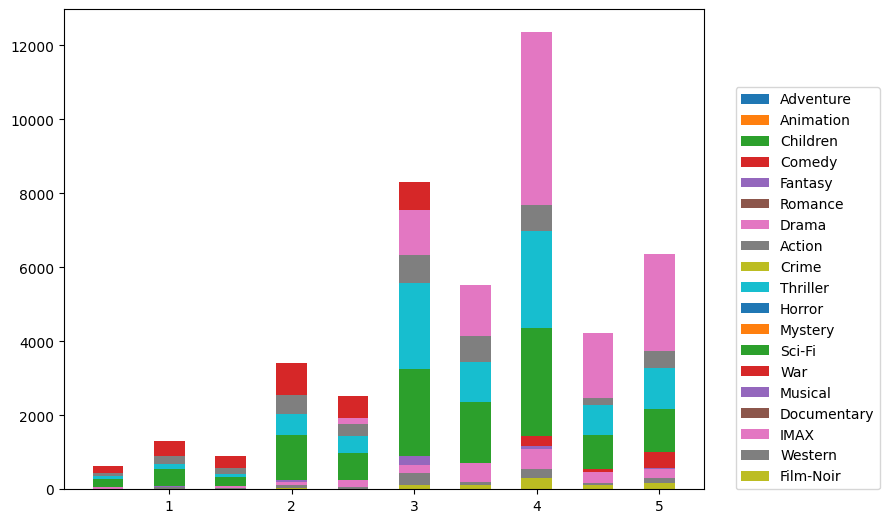

In [41]:
#extracting out all genre from moviesData using pandas
genres_unique = pd.DataFrame(moviesData.genres.str.split('|').tolist()).stack().unique()
genres_list=genres_unique[:len(genres_unique)-1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#executing Nested queries within looping structure over table join of rating and movies and doing string comparision for each genre
for genre in genres_list:
    query = '''
    SELECT rating, count(rating) 
    FROM(SELECT Rating.userId, Rating.movieId, Rating.rating, Movies.genres
         FROM Rating
         LEFT JOIN Movies
         ON Rating.movieId=Movies.movieId) AS derivedTable
    WHERE genres LIKE '%'''+genre+'''%'
    GROUP BY rating
    ORDER BY rating
    '''
    query_result=db.run_query(query)
    ax.bar(query_result['rating'],query_result['count'], width = 0.25,label=genre)
ax.legend(loc=(1.05,0),labels=genres_list)




### Observation:
instead of keeping density on the verticle axis if you try with the number of users who rated each movie between 0 -5 you will have a better and clear depiction of Right-skewed  normal distribution  and This bar graph depicts a better picture of rating distribution that looks like rightly skewed normal distribution with a mean around 3

## Time series analysis
Having Timestamp in my data allows me to further explore my data with Time series analysis which is a powerful technique that can be used to understand the various temporal patterns in our data by decomposing data into different cyclic trends. Time series analysis can also be used to predict how levels of a variable will change in the future, taking into account what has happened in the past. Sometimes time series analysis can also be helpful during feature engineering to come up with a better set of features

### Movie rating trend by week
Let's find out if there's any weekly trend in Movie ratings

<Figure size 640x480 with 0 Axes>

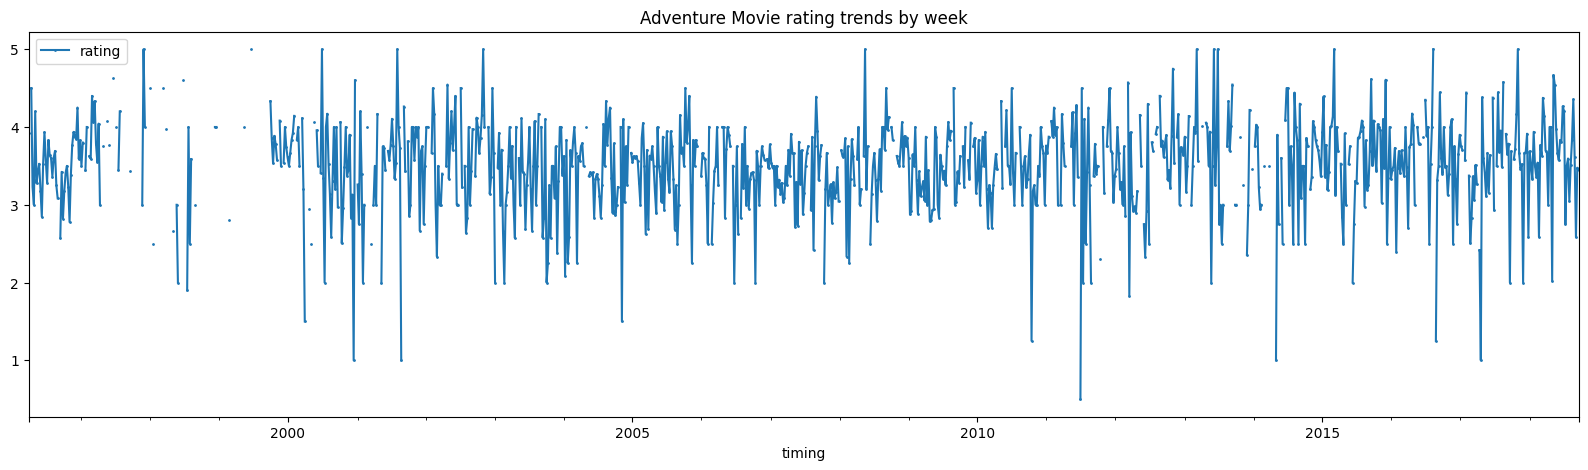

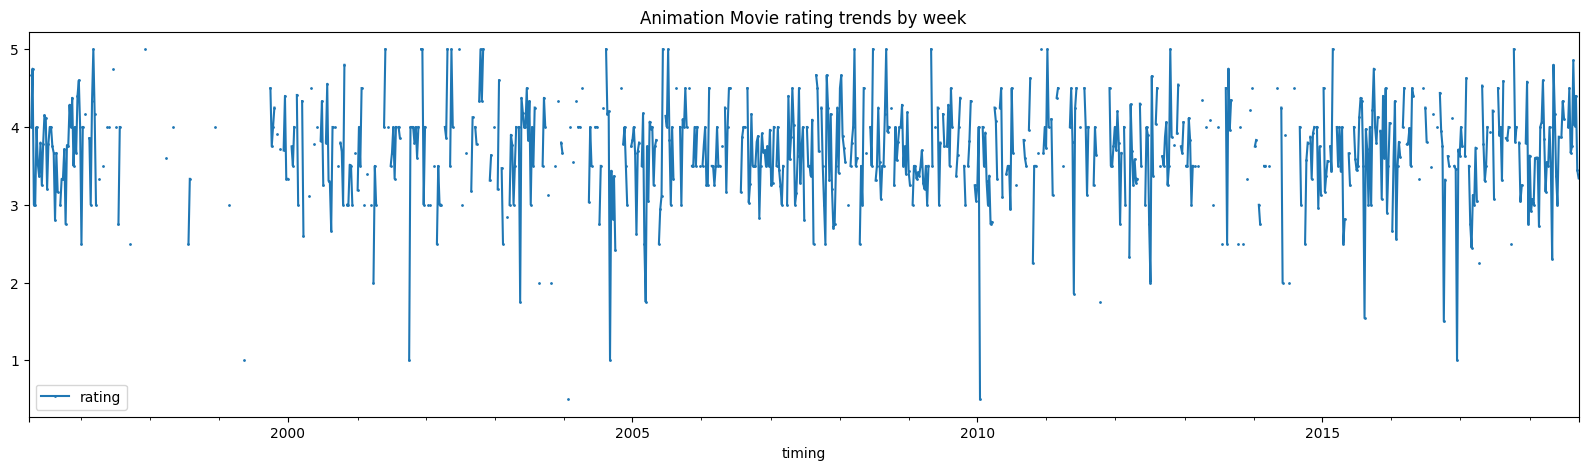

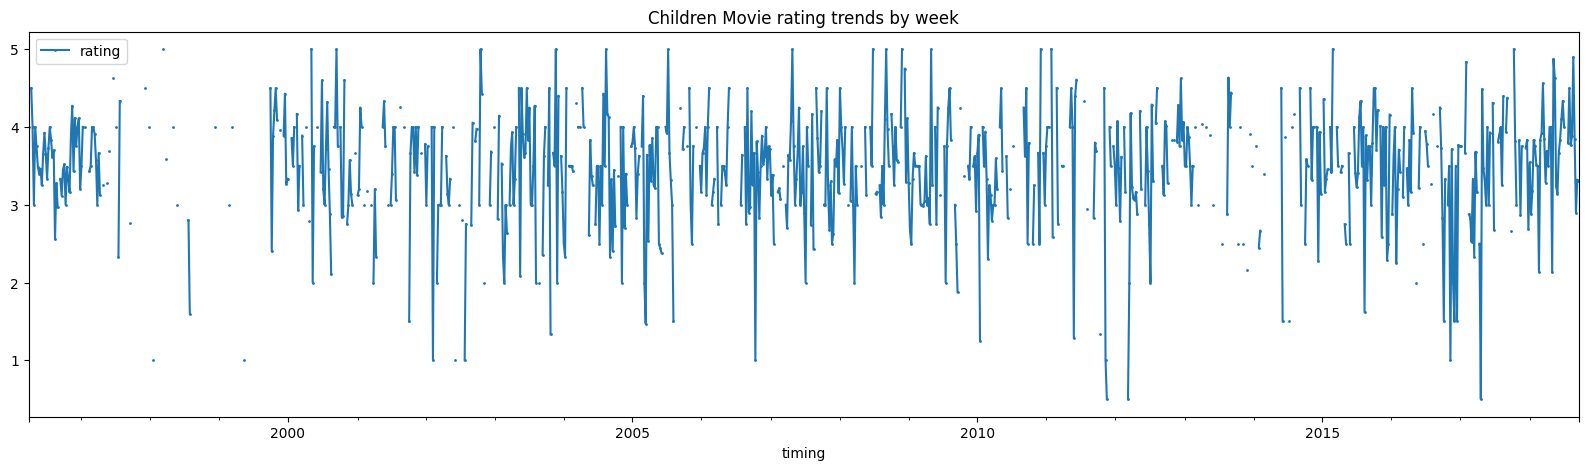

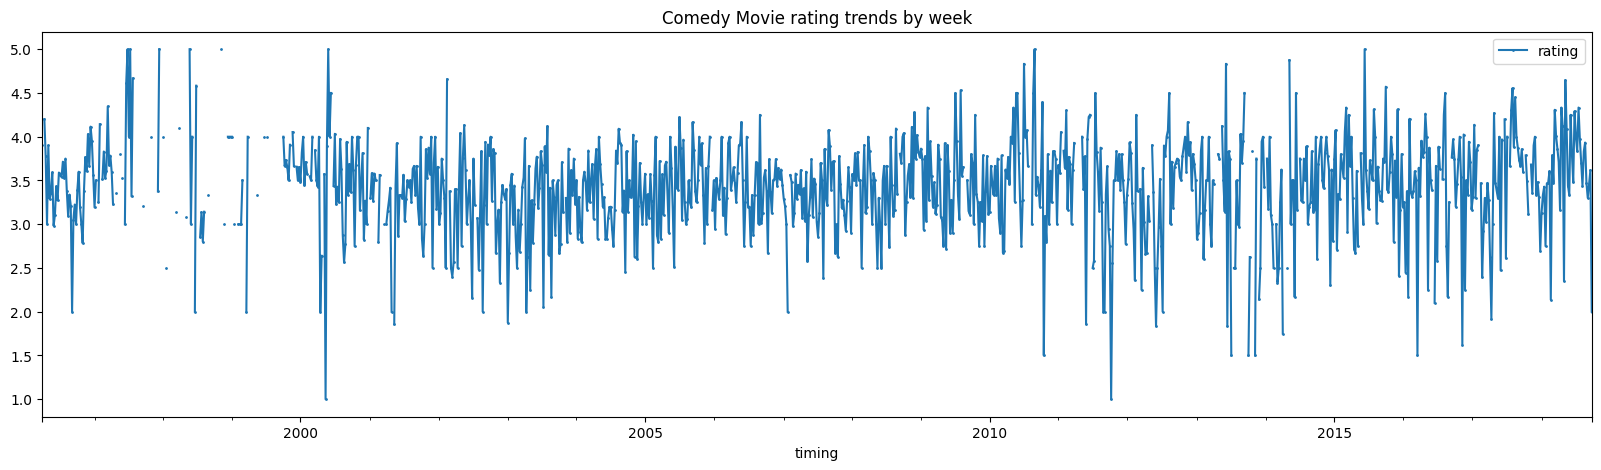

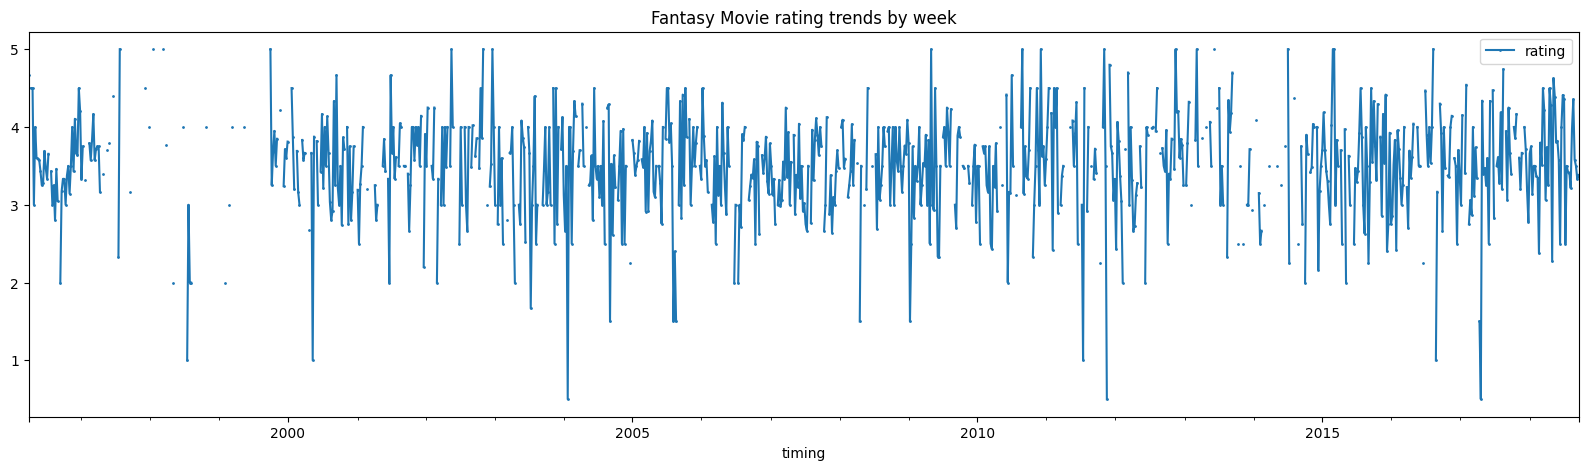

In [42]:
#from pandas.tools.plotting import andrews_curves
genres_list=genres_list[:5]
plt.figure()
#executing Nested queries within looping structure over table join of rating and movies and doing string comparision for each genre
for genre in genres_list:
    query = '''
    SELECT rating,timing
    FROM(SELECT Rating.userId, Rating.movieId, Rating.rating, Movies.genres,Rating.timing
         FROM Rating
         LEFT JOIN Movies
         ON Rating.movieId=Movies.movieId) AS derivedTable
    WHERE genres LIKE '%'''+genre+'''%'
    ORDER BY timing DESC
    '''
    query_result=db.run_query(query)
    query_result['timing']=pd.to_datetime(query_result['timing'])
    query_result.set_index('timing', inplace=True)
    query_result.resample("W").mean().plot(marker="o", markersize=1,figsize=(20,5))
    plt.title(genre+' Movie rating trends by week')


### Observation:
when resampled on weekly basis there is no weekly trend in Movie ratings it's a random cyclic time series for each genre

### Movie rating trend by Month
Let's resample and find out if there's any montly trend in my Movie ratings

<Figure size 640x480 with 0 Axes>

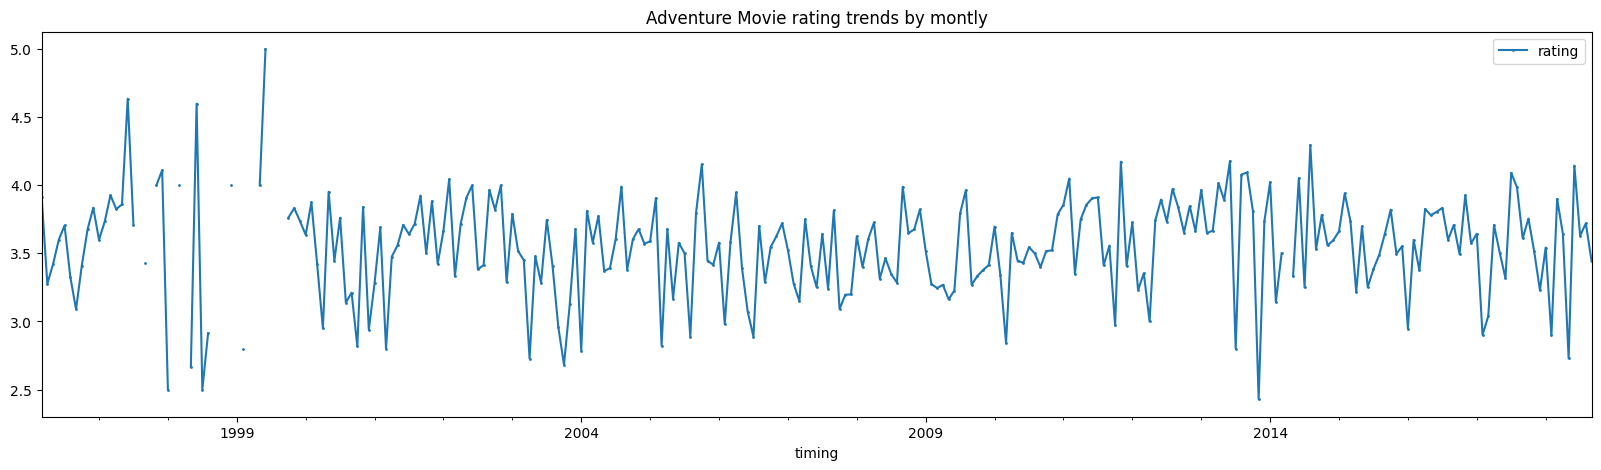

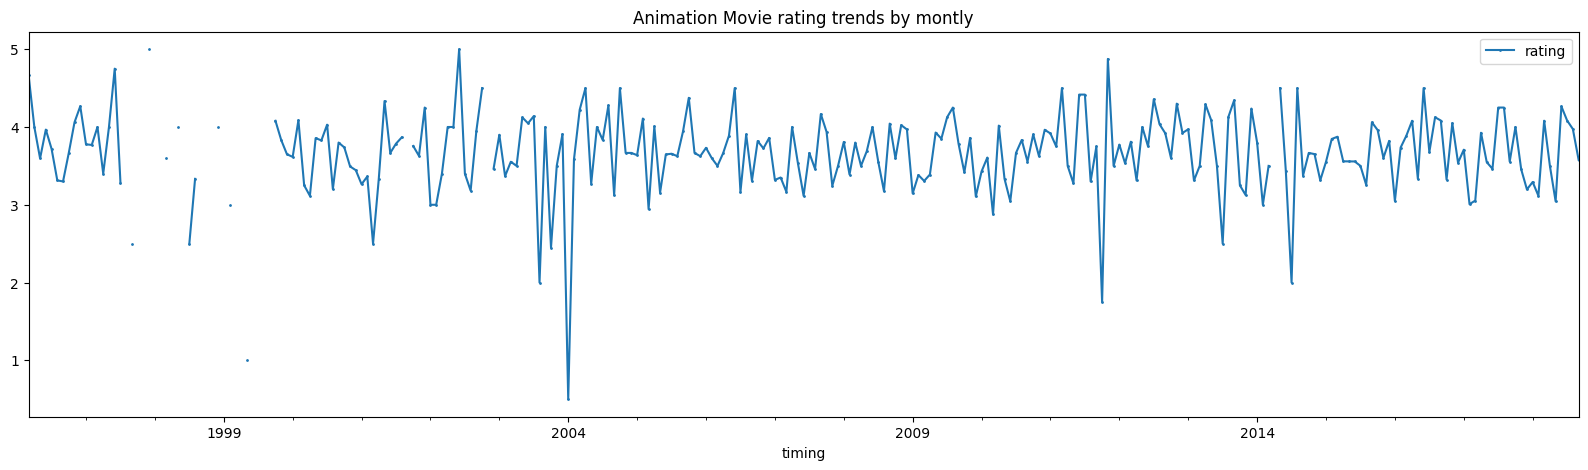

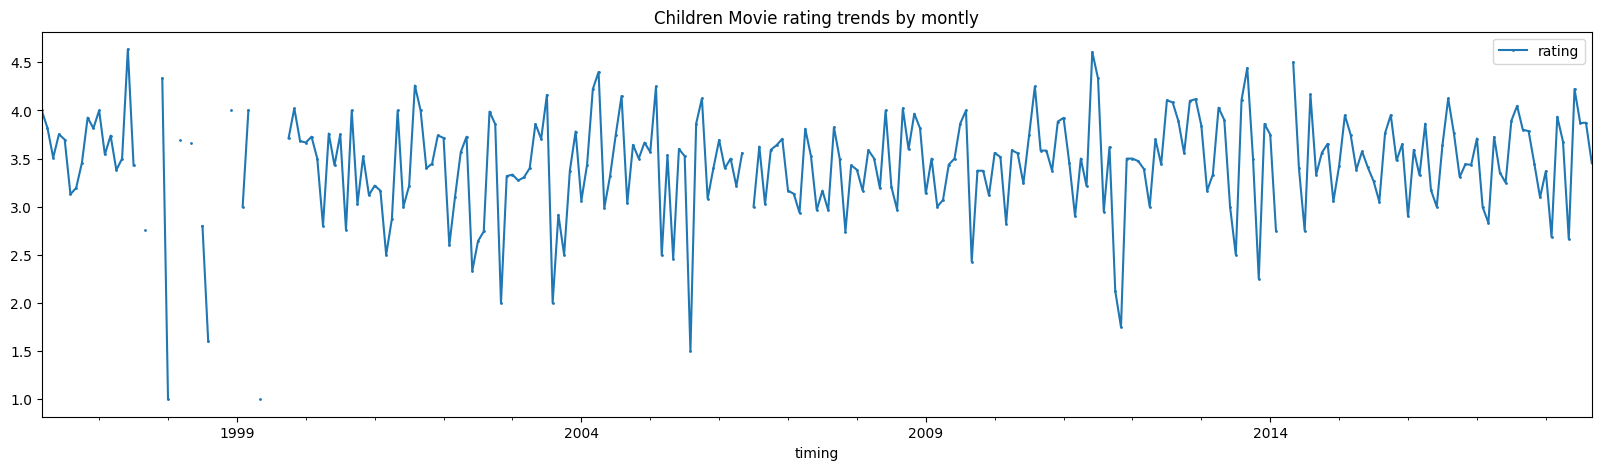

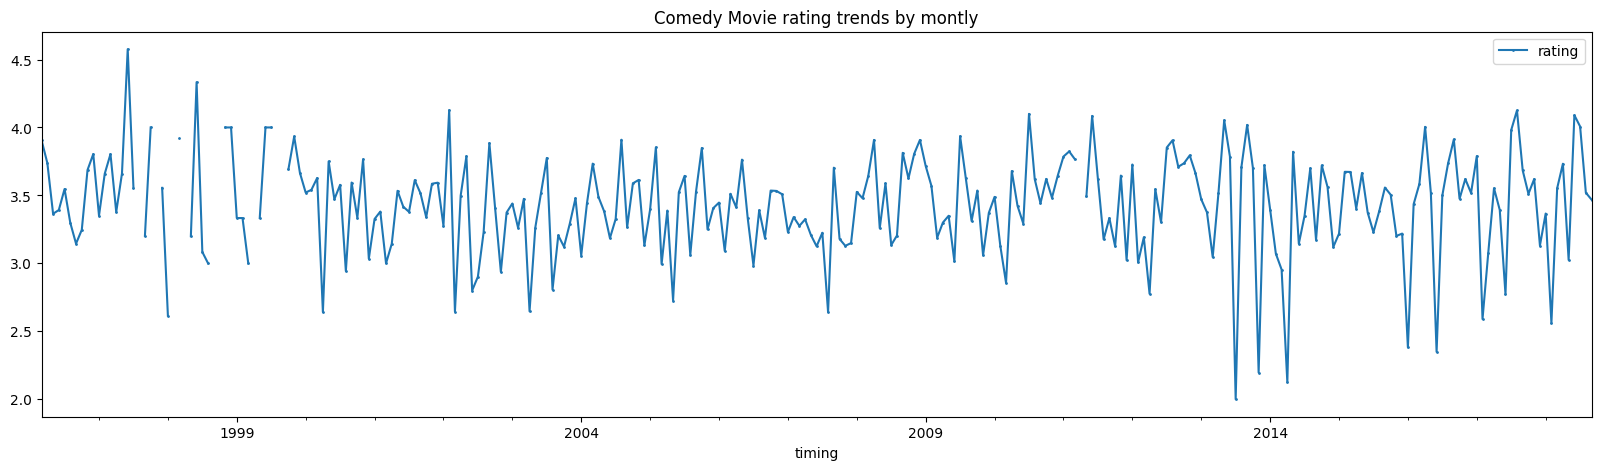

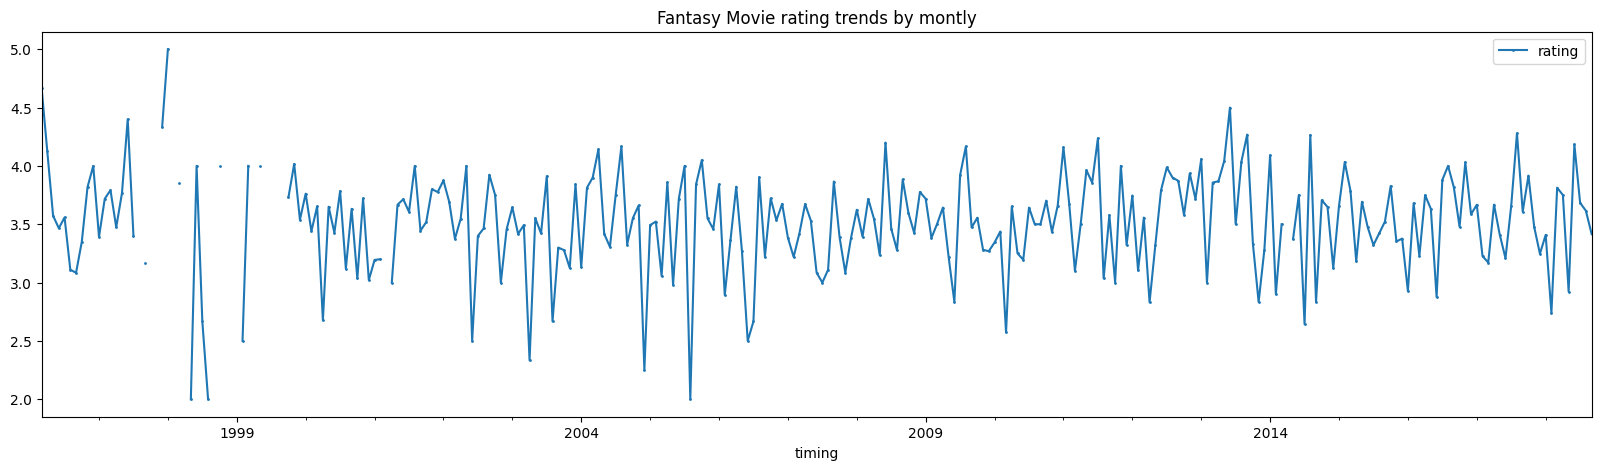

In [43]:
genres_list=genres_list[:5]
plt.figure()
#executing Nested queries within looping structure over table join of rating and movies and doing string comparision for each genre
for genre in genres_list:
    query = '''
    SELECT rating,timing
    FROM(SELECT Rating.userId, Rating.movieId, Rating.rating, Movies.genres,Rating.timing
         FROM Rating
         LEFT JOIN Movies
         ON Rating.movieId=Movies.movieId) AS derivedTable
    WHERE genres LIKE '%'''+genre+'''%'
    ORDER BY timing DESC
    '''
    query_result=db.run_query(query)
    query_result['timing']=pd.to_datetime(query_result['timing'])
    query_result.set_index('timing', inplace=True)
    query_result.resample("M").mean().plot(marker="o", markersize=1,figsize=(20,5))
    plt.title(genre+' Movie rating trends by montly')


### Observation:
Again when resampled on montly basis there is no montly trend in Movie ratings it's a random cyclic time series for each genre

### Movie rating trend by year
Let's resample and find out if there's any yearly trend in my Movie ratings

<Figure size 640x480 with 0 Axes>

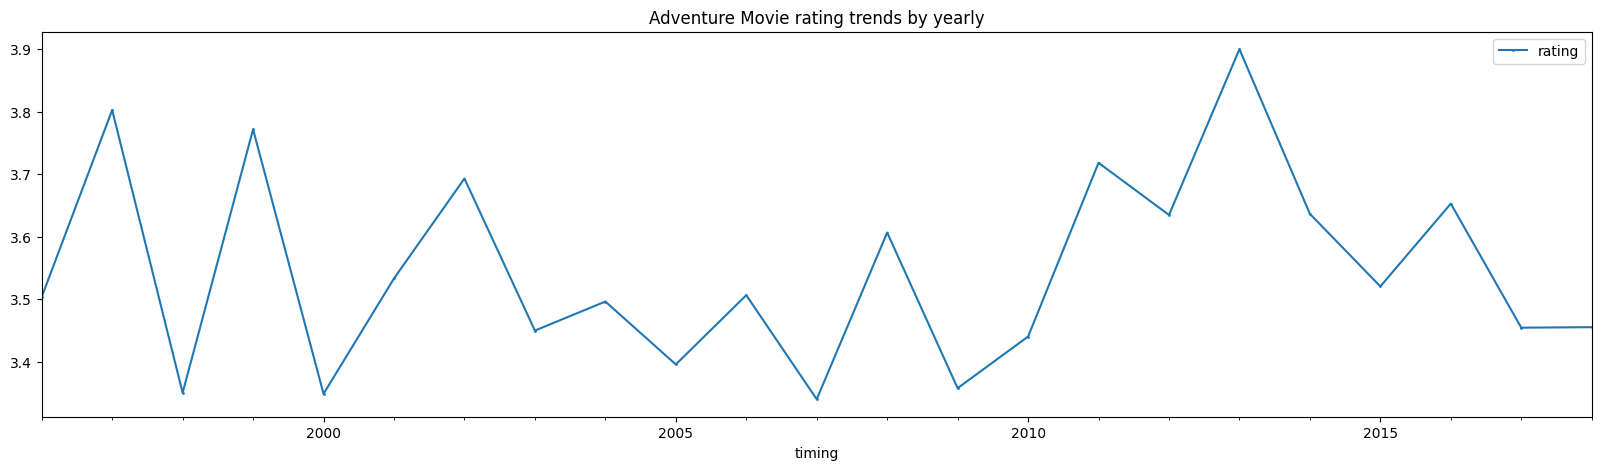

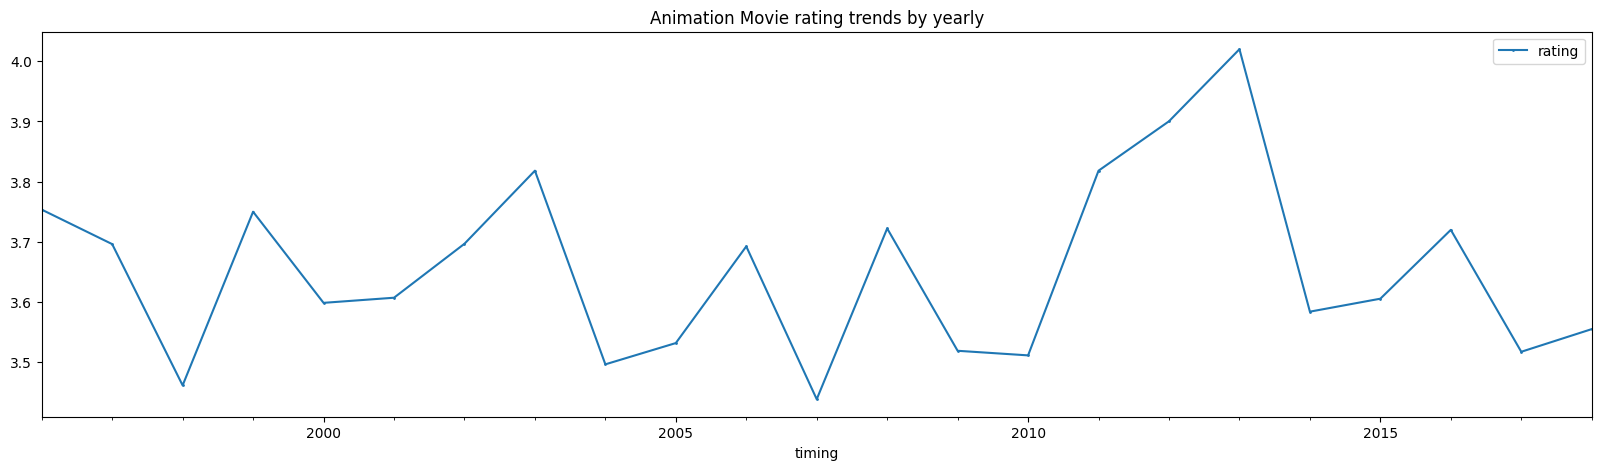

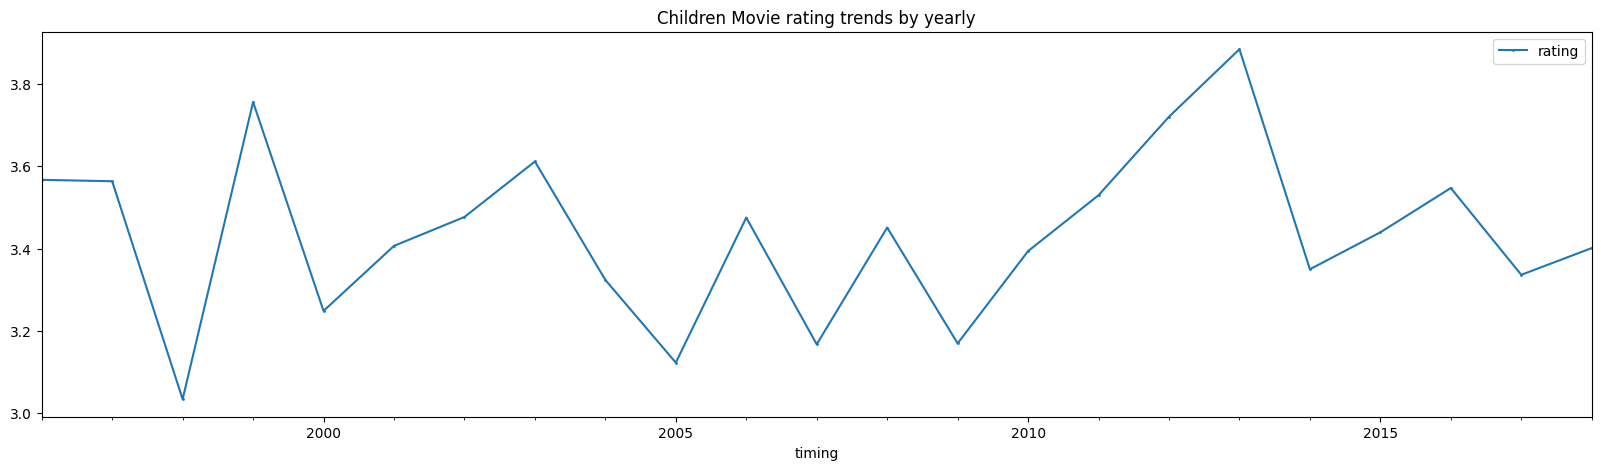

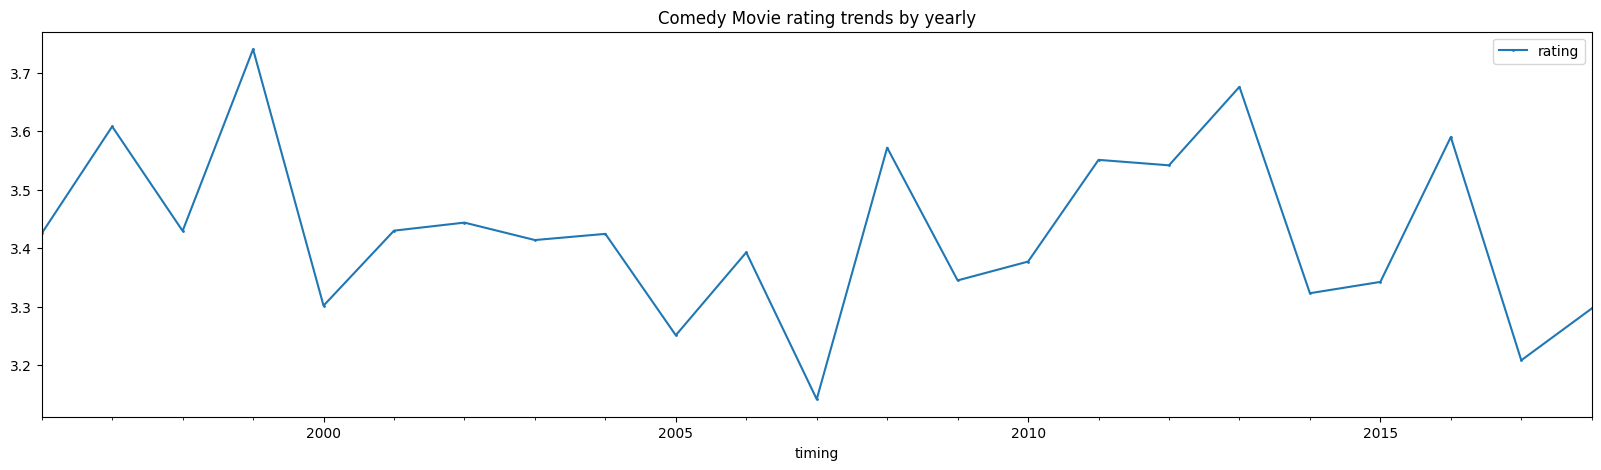

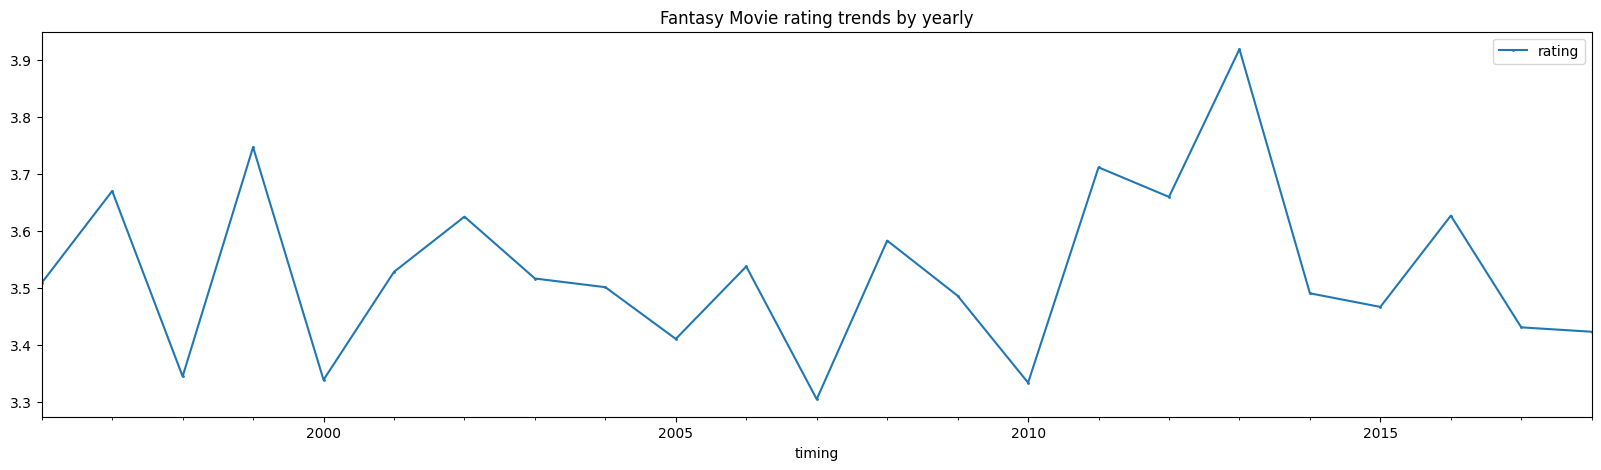

In [44]:
genres_list=genres_list[:5]
plt.figure()
#executing Nested queries within looping structure over table join of rating and movies and doing string comparision for each genre
for genre in genres_list:
    query = '''
    SELECT rating,timing
    FROM(SELECT Rating.userId, Rating.movieId, Rating.rating, Movies.genres,Rating.timing
         FROM Rating
         LEFT JOIN Movies
         ON Rating.movieId=Movies.movieId) AS derivedTable
    WHERE genres LIKE '%'''+genre+'''%'
    ORDER BY timing DESC
    '''
    query_result=db.run_query(query)
    query_result['timing']=pd.to_datetime(query_result['timing'])
    query_result.set_index('timing', inplace=True)
    query_result.resample("AS").mean().plot(marker="o", markersize=1,figsize=(20,5))
    plt.title(genre+' Movie rating trends by yearly')


# Observation:
This one is interesting although when resampled on yearly basis there is no yearly trend in Movie ratings it's a random cyclic time series  <b>But</b> if your objective is ND forecasting you can forecast any genre based on the others because they all are highly correlated and can be modeled together

# Rating distribution for Movies

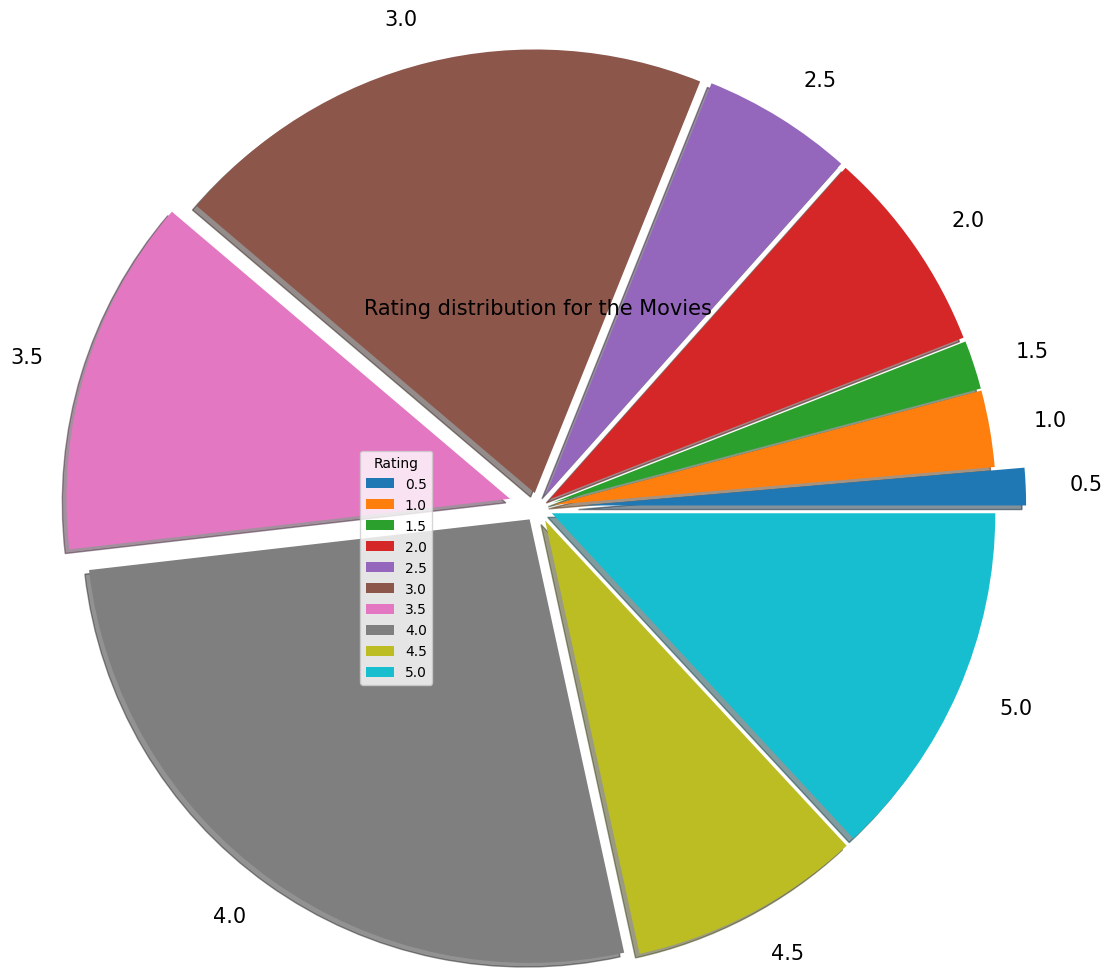

In [45]:
#executing query over rating table
query = '''
SELECT rating, count(rating)
FROM Rating
GROUP BY rating
ORDER BY rating
'''
rating_result=db.run_query(query)
y = np.array(rating_result['count'])
mylabels = rating_result['rating']
explode =[0.3,0.1,0.1,0.1,0.1,0.1,0.2,0.1,0.1,0.1]
textprops = {"fontsize":15} # Font size of text in pie chart
plt.pie(y, labels = mylabels,explode = explode,shadow = True,radius = 3,textprops =textprops)
plt.legend(title = "Rating",loc="lower left")
plt.title("Rating distribution for the Movies",fontsize=15)
plt.show() 



### Observation:
Finally, looking at the rating distribution it's easy to infer people rarely rate movies in 0.5-1.5 window but it's super common among users to rate movies between 3.0-4.0

## Conclusion
I've explored the [MovieLens small dataset ]( https://grouplens.org/datasets/movielens/latest/) which helped me better understand the data and puts the importance of EDA in the spotlight 
"Most EDA techniques are graphical with a few quantitative techniques. The reason for the heavy reliance on graphics is that by its very nature the main role of EDA is to open-mindedly explore, and graphics gives the analysts unparalleled power to do so, enticing the data to reveal its structural secrets, and being always ready to gain some new, often unsuspected, insight into the data. In combination with the natural pattern-recognition capabilities that we all possess, graphics provide, of course, unparalleled power to carry this out"

For EDA, the sequence is Problem => Data => Analysis => Model => Conclusions

The idea to use PostgreSQL for EDA gives you a sense of how the relational database works, how data in it is stored, and more importantly, you get to experience SQL in its full glory this declarative language which isn't turning complete but its flexibility to pose a rich set of queries is exceptional, every single graphical EDA technique that I have used today have only used SQL to get the desired data out of the database before plotting it you can play with your data very smoothly by using SQL instead of the panda's library the flexibility  to pose a rich set of queries in SQL is phenomenal 

## Next Step

The next step is data cleaning and feature engineering before introducing the Hybrid recommendation algorithm and coding it from scratch without using any ML libraries like scikit-learn or TensorFlow